# Project: MBTI Personality Classification Using Data Mining

## 1. Library and Tool Imports 

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing and modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# For modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Set plot style
sns.set(style='whitegrid')

### Utility Functions for plotting 

In [2]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


## 2. Import the MBTI Dataset

### 2.1 Load Dataset

In [3]:
# Load the full MBTI dataset and make a backup copy for safety

# Read the entire CSV
orig_df = pd.read_csv('dataset/mbti.csv')

# Create a working copy
df = orig_df.copy()

# Show dataset dimensions
print(f"Original dataset shape: {df.shape}")

# Display first few rows
df.head()

Original dataset shape: (8675, 2)


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


### 2.2 Dataset Info

In [4]:
# Show shape
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

# Basic info
df.info()

There are 8675 rows and 2 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


## 3. Exploratory Data Analysis (EDA)

### 3.1 Distribution graphs (histogram/bar graph) of sampled columns:

/tmp/ipykernel_36220/459572436.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='type', order=df['type'].value_counts().index, palette='Set2')


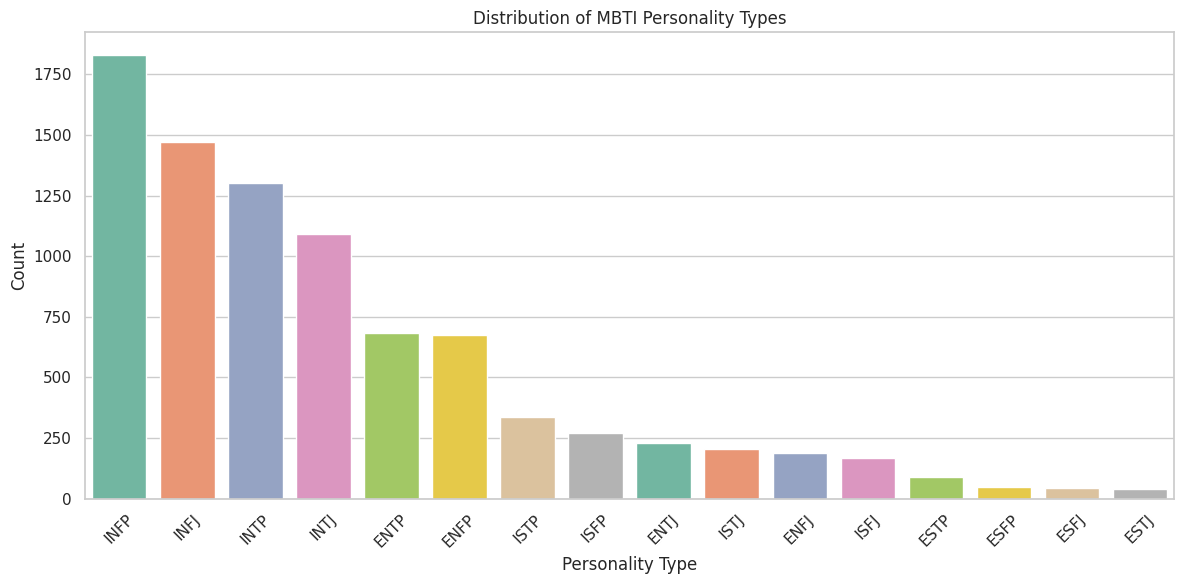

In [5]:
# Plot the number of users per personality type
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='type', order=df['type'].value_counts().index, palette='Set2')
plt.title('Distribution of MBTI Personality Types')
plt.xticks(rotation=45)
plt.xlabel('Personality Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 3.2 Average Post Length By Type 

/tmp/ipykernel_36220/146286013.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='type', y='post_length', order=avg_lengths, palette='Set2')


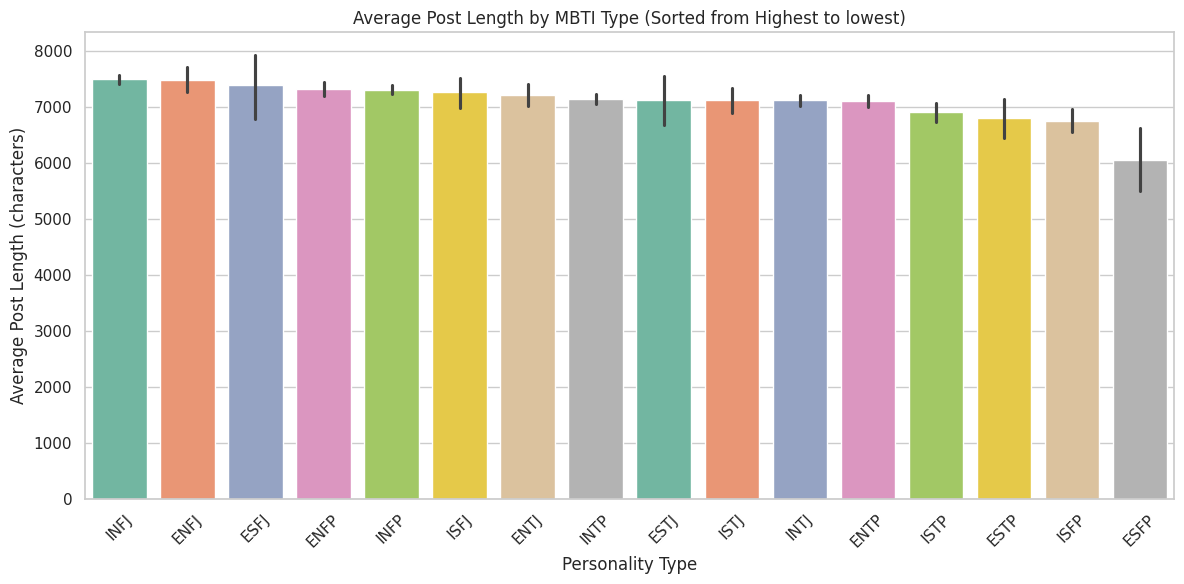

In [6]:
# Reorder types by average post length
df['post_length'] = df['posts'].apply(len)


avg_lengths = df.groupby('type')['post_length'].mean().sort_values(ascending=False).index

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='type', y='post_length', order=avg_lengths, palette='Set2')
plt.title('Average Post Length by MBTI Type (Sorted from Highest to lowest)')
plt.xticks(rotation=45)
plt.xlabel('Personality Type')
plt.ylabel('Average Post Length (characters)')
plt.tight_layout()
plt.show()

### 3.3 View Example Posts

In [7]:
# View one example post for each personality type
for mbti in df['type'].unique():
    sample = df[df['type'] == mbti].iloc[0]['posts'][:300]
    print(f"🔹 {mbti}: {sample}...\n{'-'*50}")

🔹 INFJ: 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing...
--------------------------------------------------
🔹 ENTP: 'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||He...
--------------------------------------------------
🔹 INTP: 'Good one  _____   https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes.   Or it's more I cou

### 3.4 Histogram

<Figure size 1500x1000 with 0 Axes>

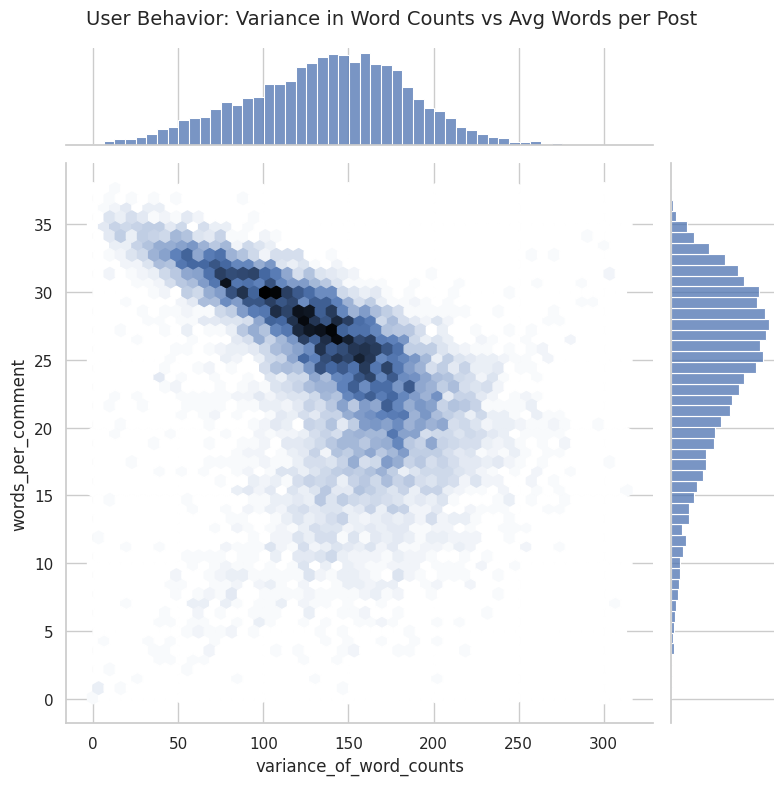

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Copy original dataframe to avoid accidental overwrite
df = df.copy()

# Helper function to compute variance of word counts in 50 posts
def var_row(row):
    return np.var([len(post.split()) for post in row.split("|||")])

# Compute new features
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split()) / 50)
df['variance_of_word_counts'] = df['posts'].apply(var_row)

# Jointplot: variance vs average words per post
plt.figure(figsize=(15, 10))
sns.jointplot(x=df["variance_of_word_counts"], y=df["words_per_comment"], kind="hex", height=8)
plt.suptitle('User Behavior: Variance in Word Counts vs Avg Words per Post', fontsize=14)
plt.tight_layout()
plt.show()


### 3.5 Distance Plot

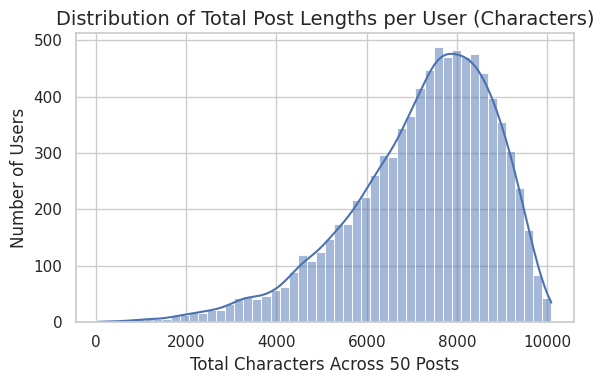

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate total character length of all 50 posts per user
df["length_posts"] = df["posts"].apply(len)

# Plot distribution using histplot (modern replacement for distplot)
plt.figure(figsize=(6, 4))
sns.histplot(df["length_posts"], kde=True, bins=50)
plt.title("Distribution of Total Post Lengths per User (Characters)", fontsize=14)
plt.xlabel("Total Characters Across 50 Posts")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()


### 3.6 Wordcloud For Each Independent Class


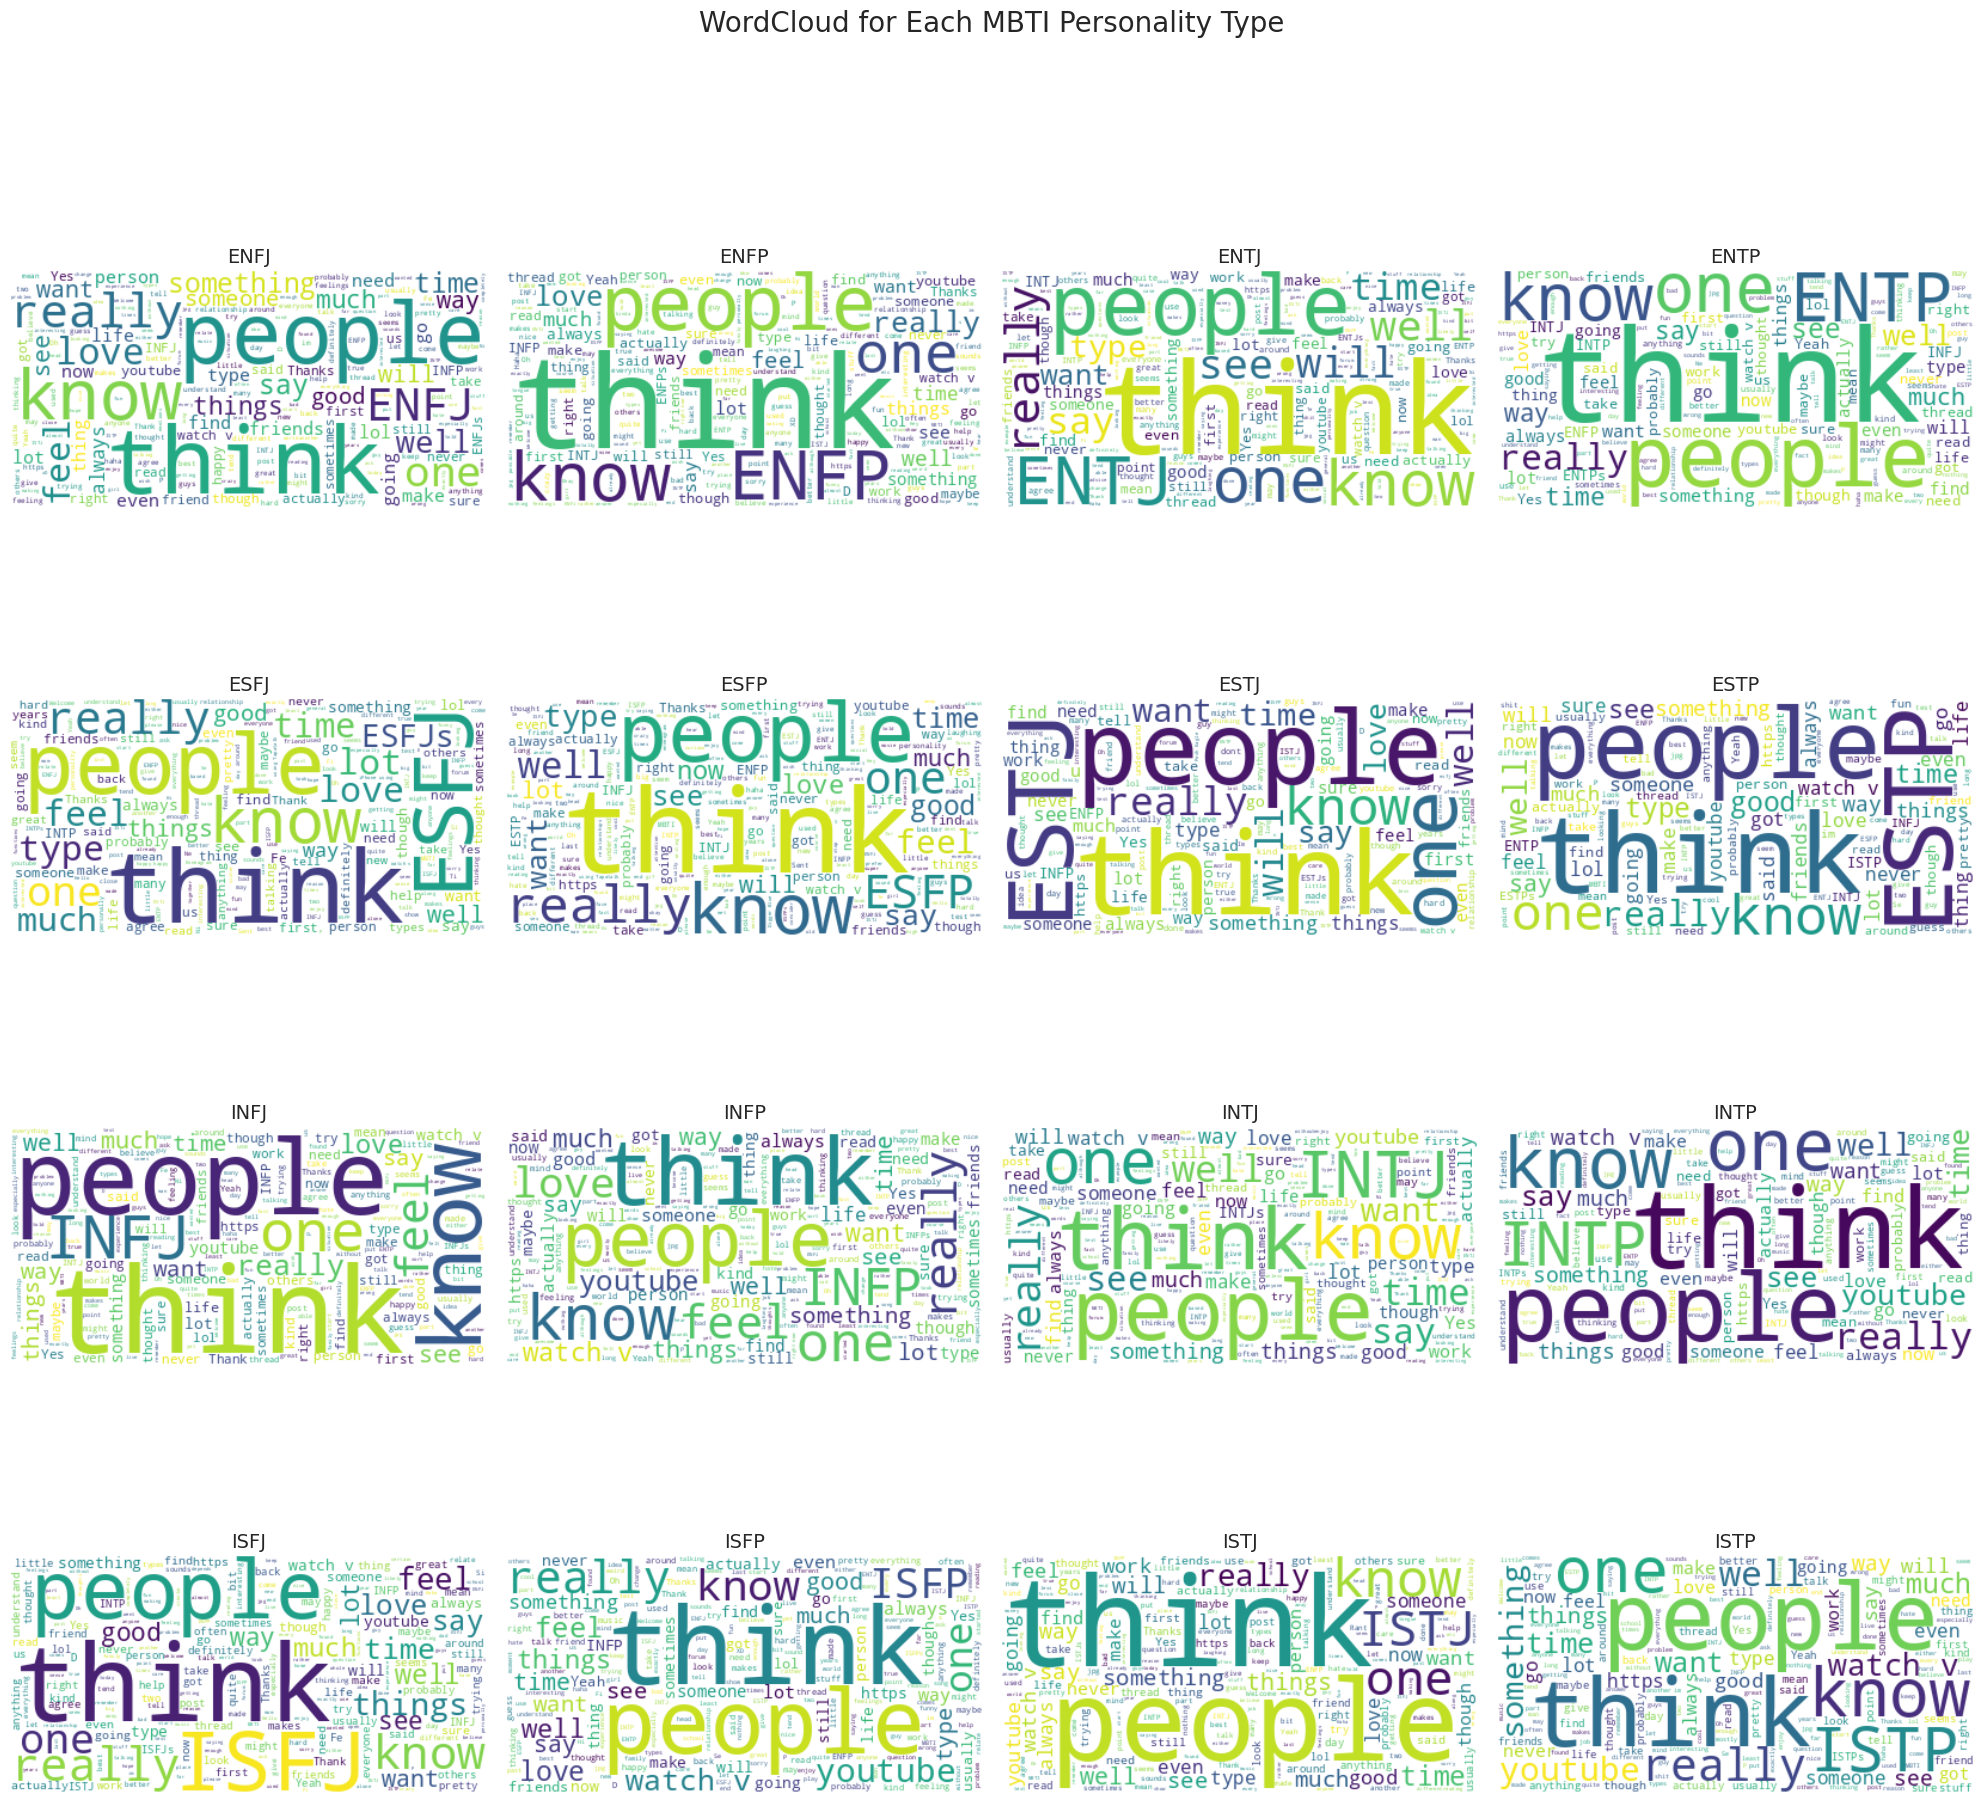

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Unique MBTI types
types = sorted(df['type'].unique())

# Grid setup
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle("WordCloud for Each MBTI Personality Type", fontsize=20)
axes = axes.flatten()  # flatten to make indexing easier

# Generate a wordcloud for each personality type
for idx, mbti_type in enumerate(types):
    subset = df[df['type'] == mbti_type]
    text = " ".join(subset['posts'].astype(str))
    wordcloud = WordCloud(
        max_words=1000,
        relative_scaling=1.0,
        normalize_plurals=False,
        background_color='white'
    ).generate(text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(mbti_type, fontsize=14)
    axes[idx].axis('off')

# Turn off any unused subplots (if dataset has <16 types)
for i in range(len(types), len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()


 ## 4. Text Preprocessing

### 4.1 Text Cleanup

In [12]:
import re
def clean_text(text):
    # Replace triple pipes with period to separate thoughts
    text = text.replace('|||', '\n')
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation and numbers except periods
    text = re.sub(r'[^a-z.\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Reapply cleaning
df['clean_posts'] = df['posts'].apply(clean_text)

### 4.2 Verify Cleanup happened

In [13]:
pd.set_option('display.max_colwidth', 100)

df_compare = df[['type', 'posts', 'clean_posts']].copy()
df_compare['Original (truncated)'] = df_compare['posts'].apply(lambda x: x[:300] + '...')
df_compare['Cleaned (truncated)'] = df_compare['clean_posts'].apply(lambda x: x[:300] + '...')

df_compare[['type', 'Original (truncated)', 'Cleaned (truncated)']].head(3)

,type,Original (truncated),Cleaned (truncated)
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1ro...,enfp and intj moments sportscenter not top ten plays pranks what has been the most lifechanging ...
1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the sam...,im finding the lack of me in these posts very alarming. sex can be boring if its in the same pos...
2,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I kno...",good one of course to which i say i know thats my blessing and my curse. does being absolutely p...


### 4.3 Text Vectorization

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,        # cap vocabulary size
    ngram_range=(1, 2),       # unigrams + bigrams
    stop_words='english'      # remove common stopwords
)

# Fit and transform the clean text
X = tfidf.fit_transform(df['clean_posts'])

# Check shape
print(f'TF-IDF matrix shape: {X.shape}')

TF-IDF matrix shape: (8675, 5000)


## 5. Train-Test Split

### 5.1 Encode the Target Labels

In [15]:
from sklearn.preprocessing import LabelEncoder

# Encode MBTI types to integers
le = LabelEncoder()
y = le.fit_transform(df['type'])

# Optional: Show label mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("MBTI Label Mapping:", label_mapping)

MBTI Label Mapping: {'ENFJ': np.int64(0), 'ENFP': np.int64(1), 'ENTJ': np.int64(2), 'ENTP': np.int64(3), 'ESFJ': np.int64(4), 'ESFP': np.int64(5), 'ESTJ': np.int64(6), 'ESTP': np.int64(7), 'INFJ': np.int64(8), 'INFP': np.int64(9), 'INTJ': np.int64(10), 'INTP': np.int64(11), 'ISFJ': np.int64(12), 'ISFP': np.int64(13), 'ISTJ': np.int64(14), 'ISTP': np.int64(15)}


### 5.2 Split the data

In [16]:
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Train size: {X_train.shape[0]}')
print(f'Test size: {X_test.shape[0]}')


Train size: 6940
Test size: 1735


## 6. Model Training with random parameters

### 6.1 Logistic Regression, Multinomial Naive Bayes, Linear SVC

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Dictionary to store model names and accuracies
results = []

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
results.append(('Logistic Regression', acc_lr))

# Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)
results.append(('Multinomial Naive Bayes', acc_nb))

# Linear Support Vector Classifier
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
results.append(('Linear Support Vector Classifier', acc_svm))


### 6.2 Decision Tree, Multi-Layer Perceptron

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
results.append(('Decision Tree', acc_dt))

# MLP Classifier (basic feed-forward NN)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
results.append(('Multilayer Perceptron (MLP)', acc_mlp))

### 6.3 XGBoost and CatBoost

In [22]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# XGBoost
xgb = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='mlogloss',
    n_estimators=50,     # Fewer trees
    max_depth=4,         # Shallower trees
    verbosity=0
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
results.append(('XGBoost Classifier', acc_xgb))

# CatBoost (silent mode to avoid clutter)
cat = CatBoostClassifier(
    iterations=50,       # Fewer trees
    depth=4,             # Shallower trees
    verbose=0
)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)
acc_cat = accuracy_score(y_test, y_pred_cat)
results.append(('CatBoost Classifier', acc_cat))


### Complement NB

In [34]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score

# Complement Naive Bayes
cnb = ComplementNB()
cnb.fit(X_train, y_train)
y_pred_cnb = cnb.predict(X_test)
acc_cnb = accuracy_score(y_test, y_pred_cnb)

# Append to original results list (v1-style)
results.append(('Complement Naive Bayes', acc_cnb))

### Preliminary Results

In [ ]:
import pandas as pd

# Create DataFrame
accuracy = pd.DataFrame(results, columns=['Model', 'Test Accuracy'])

# Sort and visualize
accuracy.sort_values(by='Test Accuracy', ascending=False, ignore_index=True)\
    .style.background_gradient(cmap='Blues')

### 7. Training models with better parameters

In [25]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
results_v2 = []

### 7.1 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params_lr = {'C': [0.1, 1, 10]}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=300, solver='saga', n_jobs=-1),
    params_lr,
    cv=3,
    scoring='accuracy'
)

grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print("Logistic Regression Best Params:", grid_lr.best_params_)
print(classification_report(y_test, y_pred_lr))

acc_lr = accuracy_score(y_test, y_pred_lr)
results_v2.append(('Logistic Regression', acc_lr))


### 7.2 Linear SVM

In [ ]:
from sklearn.svm import LinearSVC

params_svm = {'C': [0.01, 0.1, 1, 10, 100]}

grid_svm = GridSearchCV(LinearSVC(), params_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)

print("Linear SVM Best Params:", grid_svm.best_params_)
print(classification_report(y_test, y_pred_svm))

acc_svm = accuracy_score(y_test, y_pred_svm)
results_v2.append(('Linear SVM', acc_svm))


### 7.3 Multinomial Naive Bayes 

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define hyperparameter grid
params_nb = {'alpha': [0.01, 0.1, 1.0, 10.0]}

# Grid search with 3-fold CV and parallel execution
grid_nb = GridSearchCV(
    MultinomialNB(), 
    param_grid=params_nb, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1
)

# Train and evaluate
grid_nb.fit(X_train, y_train)
best_nb = grid_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test)

# Output results
print("Multinomial NB Best Params:", grid_nb.best_params_)
print(classification_report(y_test, y_pred_nb))

# Store accuracy for final comparison
acc_nb = accuracy_score(y_test, y_pred_nb)
results_v2.append(('Multinomial NB', acc_nb))



### 7.4 Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

params_dt = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), params_dt, cv=3, scoring='accuracy')
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("Decision Tree Best Params:", grid_dt.best_params_)
print(classification_report(y_test, y_pred_dt))

acc_dt = accuracy_score(y_test, y_pred_dt)
results_v2.append(('Decision Tree', acc_dt))


### 7.5 Multi Layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define wider parameter space
params_mlp = {
    'hidden_layer_sizes': [(100,), (100, 50), (128,), (64, 64)],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [300]
}

# Random search with 5-fold CV, 10 total combinations
random_mlp = RandomizedSearchCV(
    MLPClassifier(random_state=42), 
    params_mlp,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=1
)

random_mlp.fit(X_train, y_train)

best_mlp = random_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)

# Output results
print("MLP Best Params:", random_mlp.best_params_)
print(classification_report(y_test, y_pred_mlp))

# Store accuracy
acc_mlp = accuracy_score(y_test, y_pred_mlp)
results_v2.append(('MLP Classifier', acc_mlp))


### 7.6 Complement NB

In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Hyperparameter grid
params_cnb = {'alpha': [0.01, 0.1, 1.0, 10.0]}

# Grid search with 3-fold CV and parallel processing
grid_cnb = GridSearchCV(
    ComplementNB(), 
    param_grid=params_cnb, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1
)

# Train
grid_cnb.fit(X_train, y_train)
best_cnb = grid_cnb.best_estimator_
y_pred_cnb = best_cnb.predict(X_test)

# Output
print("Complement NB Best Params:", grid_cnb.best_params_)
print(classification_report(y_test, y_pred_cnb))

# Optional: Get accuracy but don't append to results
acc_cnb = accuracy_score(y_test, y_pred_cnb)
print(f"Complement NB Test Accuracy: {acc_cnb:.4f}")
results_v2.append(('Complement NB', acc_cnb))

In [43]:
# Create a standard mapping from variant names to unified names
model_name_map = {
    "Linear Support Vector Classifier": "Linear SVM",
    "Multinomial NB": "Multinomial Naive Bayes",
    "Complement NB": "Complement Naive Bayes",
    "Multilayer Perceptron (MLP)": "MLP Classifier"
}

# Function to normalize model names
def normalize_names(results_list):
    return [
        (model_name_map.get(name, name), acc)
        for name, acc in results_list
    ]

# Apply to both result sets
results = normalize_names(results)
results_v2 = normalize_names(results_v2)


### 7.7 See updated results

In [ ]:
import pandas as pd

# Create DataFrames
df_v1 = pd.DataFrame(results, columns=['Model', 'Test Accuracy (Default Params)'])
df_v2 = pd.DataFrame(results_v2, columns=['Model', 'Test Accuracy (Grid Search Params)'])

# Merge and sort
merged = pd.merge(df_v1, df_v2, on='Model', how='outer')
merged['sort_val'] = pd.to_numeric(merged['Test Accuracy (Grid Search Params)'], errors='coerce')
merged = merged.sort_values(by='sort_val', ascending=False).drop(columns='sort_val').reset_index(drop=True)

# Create a version for display that keeps NaNs but still allows background gradient
styled = merged.style.background_gradient(
    subset=['Test Accuracy (Default Params)', 'Test Accuracy (Grid Search Params)'],
    cmap='Blues'
).format(na_rep='-')  # Show "-" for missing but keep them as NaN internally

styled


## 8. Evaluation

In [13]:
# Show accuracy, classification report, confusion matrix
# Optionally: ROC-AUC, macro/micro average F1-scores

## 9. Vizualization of Results

### 9.1 Confusion matrix heatmap for the best model

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for best model (e.g. Logistic Regression or Linear SVM)
cm = confusion_matrix(y_test, y_pred_xgb)  # replace with best model's predictions

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### 9.2 Per-class Accuracy 

In [ ]:
from sklearn.metrics import classification_report

# Get precision, recall, f1-score for each class
report_dict = classification_report(y_test, y_pred_xgb, target_names=le.classes_, output_dict=True)
f1_scores = {label: score['f1-score'] for label, score in report_dict.items() if label in le.classes_}

# Barplot of F1 scores per class
plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette='Set2')
plt.title('Per-Class F1 Score (Logistic Regression)')
plt.xlabel('MBTI Type')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 10. Conclusion

Some conclusion Text